# Twomes virtual home interactive inverse grey-box analysis pipeline

This Jupyter Labs notebook can be used to interactively test the Twomes inverse grey-box analysis pipeline.
Don't forget to install the requirements listed in [requirements.txt](../requirements.txt) first!

## Setting the stage

First several imports and variables need to be defined


### Imports and generic settings

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib widget


from tqdm.notebook import tqdm

from gekko import GEKKO

import sys
sys.path.append('../data/')
sys.path.append('../view/')
sys.path.append('../analysis/')

# usually, two decimals suffice for displaying DataFrames (NB internally, precision may be higher)
pd.options.display.precision = 2

%load_ext autoreload

from preprocessor import Preprocessor
from inversegreyboxmodel import Learner

%matplotlib inline
%matplotlib widget

from plotter import Plot

import logging
logging.basicConfig(level=logging.INFO, 
                    format='%(asctime)s %(levelname)-8s %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S',
                    filename='log_twomes.txt',
                   )


### Load Data from Virtual Homes

In [2]:
%%time
# Prerequisite: for this example to work, you need to have the b4b_raw_properties.parquet, located e.g. in the ../data/B4B_virtual_ds/ folder.
# One way to get this is to run B4BExtractionBackup.ipynb first
df_prop = pd.read_parquet('../data/Twomes_virtual_ds/twomes_virtualhomes_raw_properties.parquet', engine='pyarrow')

#sorting the DataFrame index is needed to get good performance on certain filters
#this guarding code to check whether DataFramews are properly sorted
if not df_prop.index.is_monotonic_increasing:
    print('df_prop needed index sorting')
    df_prop = df_prop.sort_index()  

CPU times: user 30.6 ms, sys: 20 ms, total: 50.6 ms
Wall time: 42.1 ms


In [3]:
df_prop.index.unique(level='id')

Index([ 6020012, 12010012, 15008012, 15010012, 20006012, 30004012, 30004024,
       40003012, 60002012],
      dtype='int64', name='id')

In [4]:
df_prop

temp_out__degC  wind__m_s_1  \
id       source timestamp                                                
6020012  model  2022-01-03 00:00:00+01:00           10.05         8.17   
                2022-01-03 00:15:00+01:00           10.03         8.17   
                2022-01-03 00:30:00+01:00           10.02         8.17   
                2022-01-03 00:45:00+01:00           10.00         8.17   
                2022-01-03 01:00:00+01:00            9.99         8.17   
...                                                   ...          ...   
60002012 model  2022-01-23 22:45:00+01:00            5.25         1.28   
                2022-01-23 23:00:00+01:00            5.24         1.26   
                2022-01-23 23:15:00+01:00            5.19         1.28   
                2022-01-23 23:30:00+01:00            5.14         1.30   
                2022-01-23 23:45:00+01:00            5.09         1.32   

                                           ghi__W_m_2  temp_in__degC  \
id       source timestamp                                              
6020012  model  2022-01-03 00:00:00+01:00         0.0          17.89   
                2022-01-03 00:15:00+01:00         0.0          17.88   
                2022-01-03 00:30:00+01:00         0.0          17.87   
                2022-01-03 00:45:00+01:00         0.0          17.86   
                2022-01-03 01:00:00+01:00         0.0          17.85   
...                                               ...            ...   
60002012 model  2022-01-23 22:45:00+01:00         0.0          18.34   
                2022-01-23 23:00:00+01:00         0.0          18.18   
                2022-01-23 23:15:00+01:00         0.0          18.01   
                2022-01-23 23:30:00+01:00         0.0          17.85   
                2022-01-23 23:45:00+01:00         0.0          17.68   

                                           temp_set__degC  g_use__W  e_use__W  \
id       source timestamp                                                       
6020012  model  2022-01-03 00:00:00+01:00            13.0       128        84   
                2022-01-03 00:15:00+01:00            13.0       128        92   
                2022-01-03 00:30:00+01:00            13.0       128        28   
                2022-01-03 00:45:00+01:00            13.0       128        32   
                2022-01-03 01:00:00+01:00            13.0       128        28   
...                                                   ...       ...       ...   
60002012 model  2022-01-23 22:45:00+01:00            12.5       128       228   
                2022-01-23 23:00:00+01:00            12.5       128        44   
                2022-01-23 23:15:00+01:00            12.5       128        32   
                2022-01-23 23:30:00+01:00            12.5       128        28   
                2022-01-23 23:45:00+01:00            12.5       128        32   

                                           e_ret__W  
id       source timestamp                            
6020012  model  2022-01-03 00:00:00+01:00         0  
                2022-01-03 00:15:00+01:00         0  
                2022-01-03 00:30:00+01:00         0  
                2022-01-03 00:45:00+01:00         0  
                2022-01-03 01:00:00+01:00         0  
...                                             ...  
60002012 model  2022-01-23 22:45:00+01:00         0  
                2022-01-23 23:00:00+01:00         0  
                2022-01-23 23:15:00+01:00         0  
                2022-01-23 23:30:00+01:00         0  
                2022-01-23 23:45:00+01:00         0  

[18144 rows x 8 columns]

### Convert virtual home property data to preprocessed data

In [5]:
# for virtual home data (with no noise and measurement errors), preprocessing is trivial; just unstack source and prefix source to property name
df_prep = Preprocessor.unstack_prop(df_prop)

In [6]:
df_prep.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 18144 entries, (6020012, Timestamp('2022-01-03 00:00:00+0100', tz='Europe/Amsterdam')) to (60002012, Timestamp('2022-01-23 23:45:00+0100', tz='Europe/Amsterdam'))
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   model_temp_out__degC  18144 non-null  float64
 1   model_wind__m_s_1     18144 non-null  float64
 2   model_ghi__W_m_2      18144 non-null  float64
 3   model_temp_in__degC   18144 non-null  float64
 4   model_temp_set__degC  18144 non-null  float64
 5   model_g_use__W        18144 non-null  int64  
 6   model_e_use__W        18144 non-null  int64  
 7   model_e_ret__W        18144 non-null  int64  
dtypes: float64(5), int64(3)
memory usage: 1.2 MB


In [7]:
df_prep

model_temp_out__degC  model_wind__m_s_1  \
id       timestamp                                                            
6020012  2022-01-03 00:00:00+01:00                 10.05               8.17   
         2022-01-03 00:15:00+01:00                 10.03               8.17   
         2022-01-03 00:30:00+01:00                 10.02               8.17   
         2022-01-03 00:45:00+01:00                 10.00               8.17   
         2022-01-03 01:00:00+01:00                  9.99               8.17   
...                                                  ...                ...   
60002012 2022-01-23 22:45:00+01:00                  5.25               1.28   
         2022-01-23 23:00:00+01:00                  5.24               1.26   
         2022-01-23 23:15:00+01:00                  5.19               1.28   
         2022-01-23 23:30:00+01:00                  5.14               1.30   
         2022-01-23 23:45:00+01:00                  5.09               1.32   

                                    model_ghi__W_m_2  model_temp_in__degC  \
id       timestamp                                                          
6020012  2022-01-03 00:00:00+01:00               0.0                17.89   
         2022-01-03 00:15:00+01:00               0.0                17.88   
         2022-01-03 00:30:00+01:00               0.0                17.87   
         2022-01-03 00:45:00+01:00               0.0                17.86   
         2022-01-03 01:00:00+01:00               0.0                17.85   
...                                              ...                  ...   
60002012 2022-01-23 22:45:00+01:00               0.0                18.34   
         2022-01-23 23:00:00+01:00               0.0                18.18   
         2022-01-23 23:15:00+01:00               0.0                18.01   
         2022-01-23 23:30:00+01:00               0.0                17.85   
         2022-01-23 23:45:00+01:00               0.0                17.68   

                                    model_temp_set__degC  model_g_use__W  \
id       timestamp                                                         
6020012  2022-01-03 00:00:00+01:00                  13.0             128   
         2022-01-03 00:15:00+01:00                  13.0             128   
         2022-01-03 00:30:00+01:00                  13.0             128   
         2022-01-03 00:45:00+01:00                  13.0             128   
         2022-01-03 01:00:00+01:00                  13.0             128   
...                                                  ...             ...   
60002012 2022-01-23 22:45:00+01:00                  12.5             128   
         2022-01-23 23:00:00+01:00                  12.5             128   
         2022-01-23 23:15:00+01:00                  12.5             128   
         2022-01-23 23:30:00+01:00                  12.5             128   
         2022-01-23 23:45:00+01:00                  12.5             128   

                                    model_e_use__W  model_e_ret__W  
id       timestamp                                                  
6020012  2022-01-03 00:00:00+01:00              84               0  
         2022-01-03 00:15:00+01:00              92               0  
         2022-01-03 00:30:00+01:00              28               0  
         2022-01-03 00:45:00+01:00              32               0  
         2022-01-03 01:00:00+01:00              28               0  
...                                            ...             ...  
60002012 2022-01-23 22:45:00+01:00             228               0  
         2022-01-23 23:00:00+01:00              44               0  
         2022-01-23 23:15:00+01:00              32               0  
         2022-01-23 23:30:00+01:00              28               0  
         2022-01-23 23:45:00+01:00              32               0  

[18144 rows x 8 columns]

In [8]:
%autoreload 2
units_to_mathtext = property_types = {
    'degC' : r'$°C$',
    'ppm' : r'$ppm$',
    '0' : r'$[-]$',
    'bool': r'$0 = False; 1 = True$',
    'p' : r'$persons$',
    'W' : r'$W$',
    'W_m_2' : r'$W/m^{2}$',
    'm_s_1' : r'$m/s$'    
}

In [9]:
# visuaize all input data
df_plot = df_prep

In [10]:
df_plot.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 18144 entries, (6020012, Timestamp('2022-01-03 00:00:00+0100', tz='Europe/Amsterdam')) to (60002012, Timestamp('2022-01-23 23:45:00+0100', tz='Europe/Amsterdam'))
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   model_temp_out__degC  18144 non-null  float64
 1   model_wind__m_s_1     18144 non-null  float64
 2   model_ghi__W_m_2      18144 non-null  float64
 3   model_temp_in__degC   18144 non-null  float64
 4   model_temp_set__degC  18144 non-null  float64
 5   model_g_use__W        18144 non-null  int64  
 6   model_e_use__W        18144 non-null  int64  
 7   model_e_ret__W        18144 non-null  int64  
dtypes: float64(5), int64(3)
memory usage: 1.2 MB


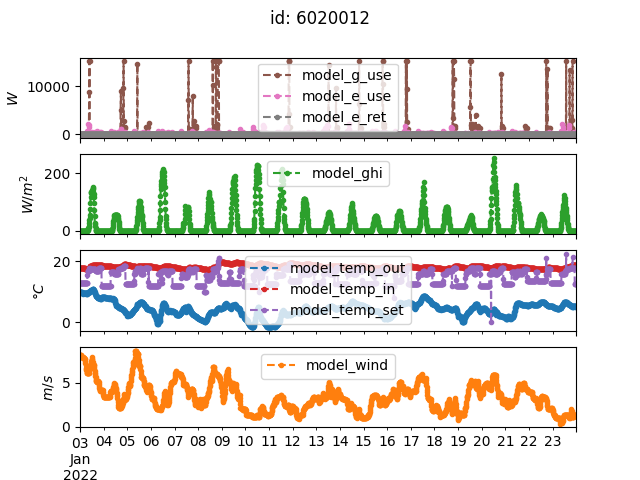

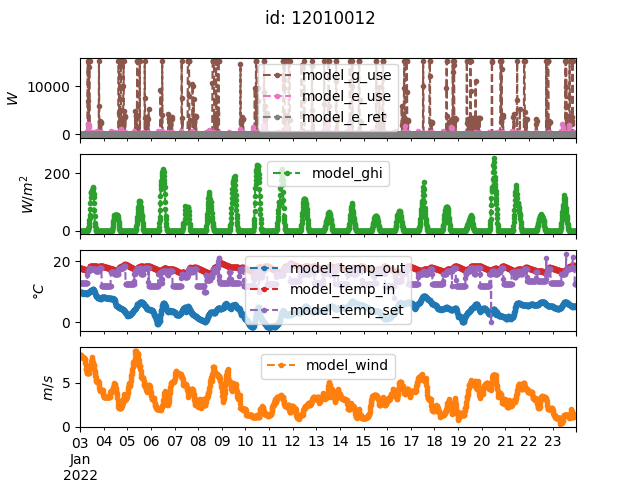

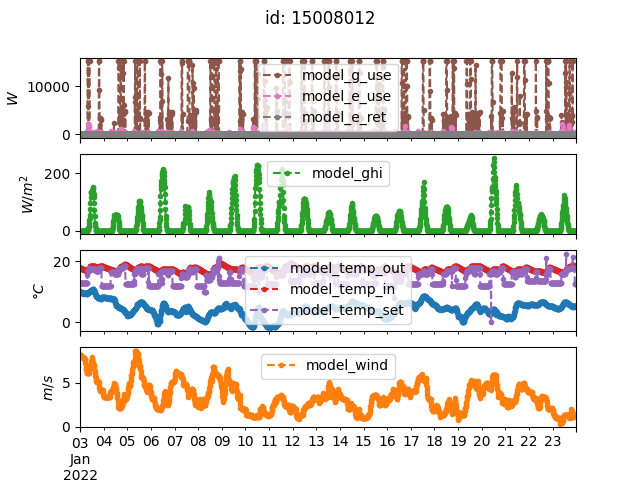

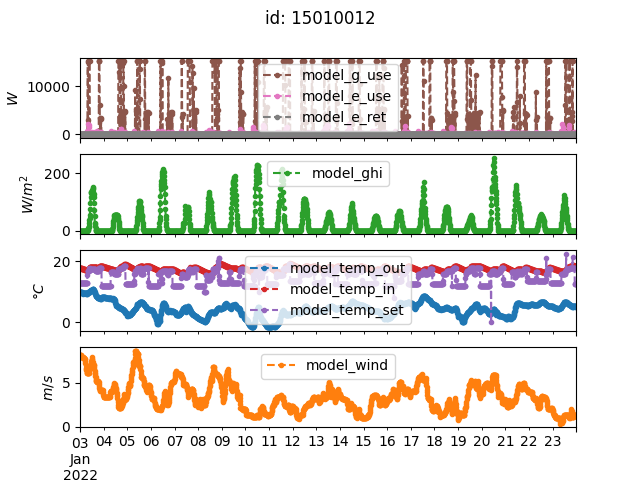

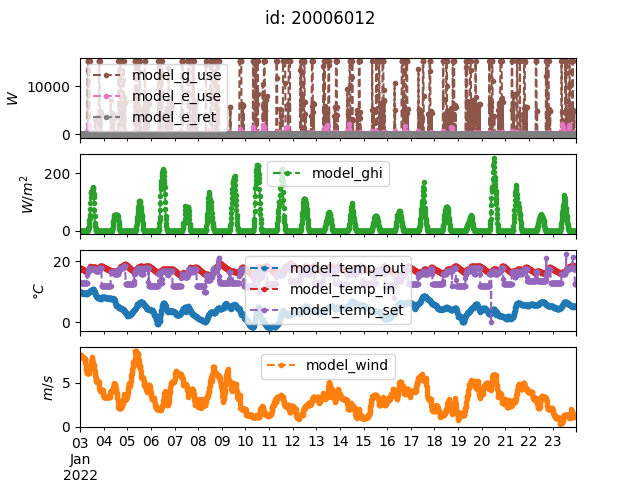

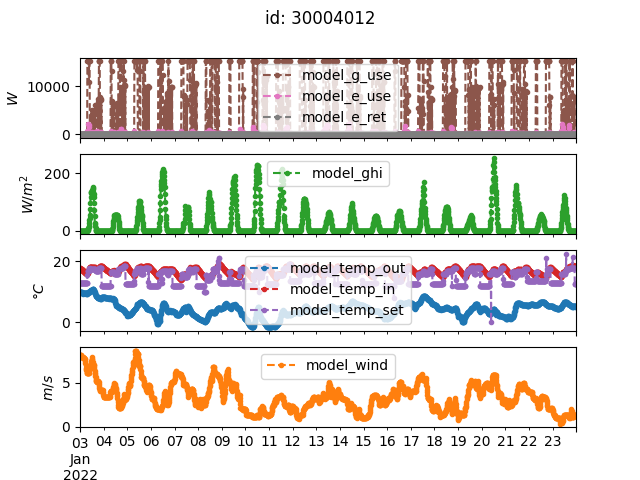

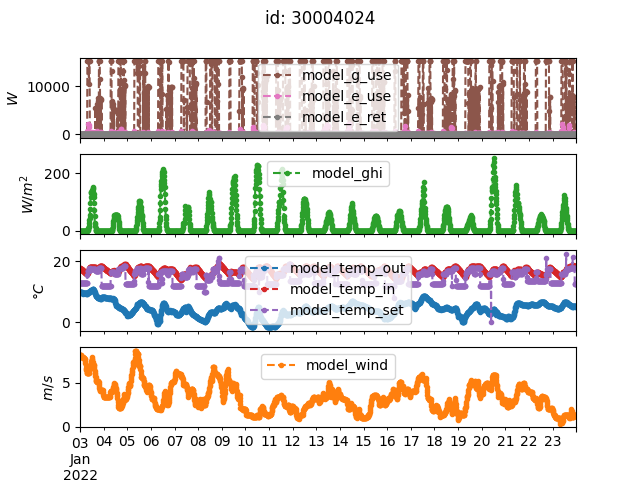

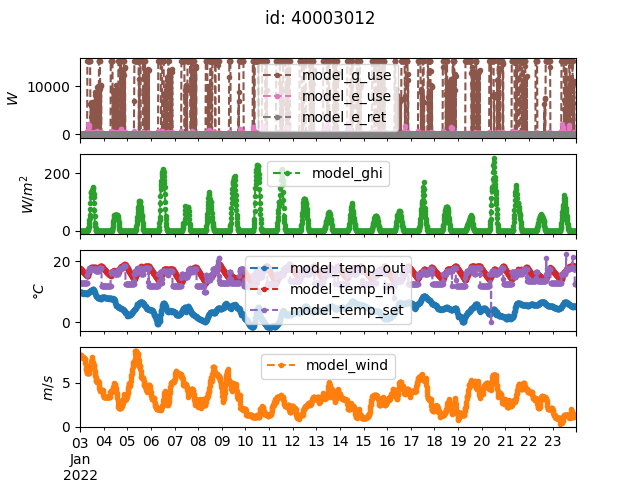

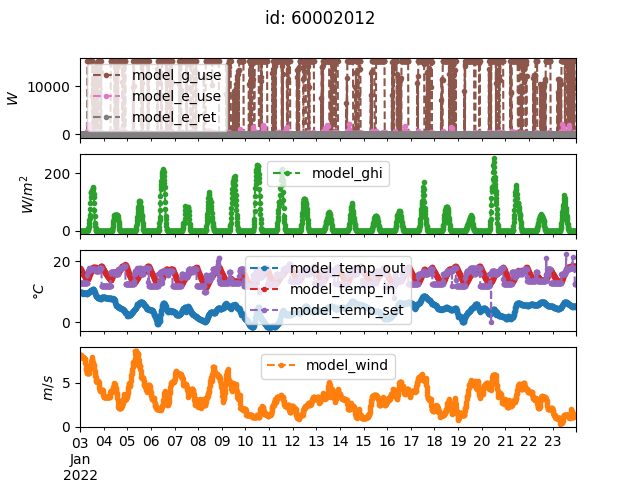

In [11]:
#Plot all properties from all sources for all ids
Plot.dataframe_preprocessed_plot(df_plot, units_to_mathtext)

## Learn parameters using inverse grey-box analysis

Most of the heavy lifting is done by the `learn_home_parameters()` function, which again uses the [GEKKO Python](https://machinelearning.byu.edu/) dynamic optimization toolkit.

In [12]:
%%time 
%autoreload 2

hints = {
    'A_sol__m2': 12.0,                                  # initial estimate for apparent solar aperture
    'eta_sup_CH__0' : 0.97,                             # average home heating efficiency of a gas boiler (superior value)
    'eta_sup_noCH__0' : 0.34,                           # average home heating efficiency indirecly DHW & cooking (superior value)
    'g_noCH__m3_a_1' : 339,                             # average gas use in m^3 per year for other purposes than home heating 
    'occupancy__p' : (2.2 * 7.7/24),                    # average house occupancy (2.2 persons, 7.7 of 24 hours)
    'Q_gain_int__W_p_1' : (77 * 8.6/24 + 105 * 7.7/24), # average heat gain per occupant (77 W for 8.6 hours, 105 W for 7.7 hours)
    'wind_chill__degC_s_m_1' : 0.67                     # average for Dutch homes, according to KNMI: https://cdn.knmi.nl/knmi/pdf/bibliotheek/knmipubmetnummer/knmipub219.pdf 
}

learn = ['A_sol__m2', 'wind_chill__degC_s_m_1']

#select column names
property_sources = {
    'temp_in__degC' : 'model_temp_in__degC',
    'temp_out__degC' : 'model_temp_out__degC',
    'wind__m_s_1' : 'model_wind__m_s_1',
    'ghi__W_m_2' : 'model_ghi__W_m_2', 
    'g_use__W' : 'model_g_use__W',
    'e_use__W' : 'model_e_use__W',
    'e_ret__W' : 'model_e_ret__W'
}

# learn the model parameters and write results to a dataframe
df_results_per_period, df_results = Learner.learn_home_parameters(df_prep, 
                                                                  property_sources = property_sources,
                                                                  learn = learn,
                                                                  hints = hints,
                                                                  ev_type = 2
                                                                 )

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

CPU times: user 1.33 s, sys: 89.8 ms, total: 1.41 s
Wall time: 46.4 s


### Result per learning period

In [13]:
df_results_per_period

,learn_streak_period_start,learn_streak_period_end,step__s,duration__s,EV_TYPE,mae_temp_in__degC,rmse_temp_in__degC,learned_H__W_K_1,actual_H__W_K_1,mae_H__W_K_1,...,actual_C__Wh_K_1,mae_C__Wh_K_1,learned_A_sol__m2,actual_A_sol__m2,mae_A_sol__m2,learned_eta_sup_CH__0,actual_eta_sup_CH__0,mae_eta_sup_CH__0,learned_wind_chill__degC_s_m_1,mae_wind_chill__degC_s_m_1
id,,,,,,,,,,,,,,,,,,,,,
6020012,2022-01-03 00:00:00+01:00,2022-01-09 23:45:00+01:00,900.0,604800.0,2,0.10,0.13,17.73,60.0,42.27,...,12000.0,8737.24,2.99,12.0,9.01,NaN,0.97,NaN,2.54,1.87e+00
6020012,2022-01-10 00:00:00+01:00,2022-01-16 23:45:00+01:00,900.0,604800.0,2,0.12,0.13,28.74,60.0,31.26,...,12000.0,7394.12,3.69,12.0,8.31,NaN,0.97,NaN,0.91,2.42e-01
6020012,2022-01-17 00:00:00+01:00,2022-01-23 23:30:00+01:00,900.0,603900.0,2,0.12,0.14,27.96,60.0,32.04,...,12000.0,7468.48,3.59,12.0,8.41,NaN,0.97,NaN,0.66,8.62e-03
12010012,2022-01-03 00:00:00+01:00,2022-01-09 23:45:00+01:00,900.0,604800.0,2,0.04,0.08,93.49,120.0,26.51,...,12000.0,2134.27,9.25,12.0,2.75,NaN,0.97,NaN,0.72,4.73e-02
12010012,2022-01-10 00:00:00+01:00,2022-01-16 23:45:00+01:00,900.0,604800.0,2,0.05,0.08,93.23,120.0,26.77,...,12000.0,2343.30,8.42,12.0,3.58,NaN,0.97,NaN,0.74,7.15e-02
12010012,2022-01-17 00:00:00+01:00,2022-01-23 23:30:00+01:00,900.0,603900.0,2,0.04,0.07,94.04,120.0,25.96,...,12000.0,2352.56,8.80,12.0,3.20,NaN,0.97,NaN,0.65,1.61e-02
15008012,2022-01-03 00:00:00+01:00,2022-01-09 23:45:00+01:00,900.0,604800.0,2,0.06,0.09,124.24,150.0,25.76,...,12000.0,1537.58,9.77,12.0,2.23,NaN,0.97,NaN,0.70,2.96e-02
15008012,2022-01-10 00:00:00+01:00,2022-01-16 23:45:00+01:00,900.0,604800.0,2,0.06,0.09,123.22,150.0,26.78,...,12000.0,1768.79,8.80,12.0,3.20,NaN,0.97,NaN,0.74,6.85e-02
15008012,2022-01-17 00:00:00+01:00,2022-01-23 23:30:00+01:00,900.0,603900.0,2,0.05,0.08,123.75,150.0,26.25,...,12000.0,1741.54,9.53,12.0,2.47,NaN,0.97,NaN,0.69,2.42e-02


In [ ]:
# show essential statistics for the learned values
df_stats = df_results_per_period.describe().filter(regex='^actual_|^learned_')
df_stats.loc[df_stats.index.get_level_values(0).isin(['mean', 'std', 'min', 'max'])]

In [ ]:
# show essential statistics for the errors
df_stats = df_results_per_period.describe().filter(regex='^mae_|^rmse')
df_stats.loc[df_stats.index.get_level_values(0).isin(['mean', 'std', 'min', 'max'])]

In [ ]:
# show essential statistics for the error values, per id
df_stats = df_results_per_period.groupby('id').describe().stack().filter(regex='^mae_|^rmse')
df_stats.loc[df_stats.index.get_level_values(1).isin(['mean', 'std', 'min', 'max'])]

### Result Visualization

In [ ]:
df_results

In [ ]:
df_plot = df_prep[[prop for prop in df_prep.columns.values if prop.split('__')[-1] == 'degC']]

In [ ]:
#Plot only temperatures from all sources for all ids
Plot.dataframe_preprocessed_plot(df_plot, units_to_mathtext)

In [ ]:
df_lot = df_prep

In [ ]:
#Plot all properties from all sources for all ids
Plot.dataframe_preprocessed_plot(df_plot, units_to_mathtext)